In [32]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.random.set_seed(42)

In [33]:
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        initializer = tf.keras.initializers.GlorotUniform(seed=42)
        self.dense1 = Dense(512, activation='relu', kernel_initializer=initializer)
        self.dense2 = Dense(256, activation='relu', kernel_initializer=initializer)
        self.dense3 = Dense(128, activation='relu', kernel_initializer=initializer)
        self.dense4 = Dense(latent_dim, activation='softplus', kernel_initializer=initializer)

    def sample(self, alpha_hat, alpha, beta):
        shape = (alpha_hat.get_shape().as_list()[-2],alpha_hat.get_shape().as_list()[-1])
        u = tf.random.uniform(shape=shape, minval=0, maxval=1)
        v = tf.math.multiply(u,alpha)
        v = tf.math.multiply(v, tf.math.exp(tf.math.lgamma(alpha)))
        v = tf.math.pow(v, tf.math.divide(1.0,alpha))
        v = tf.math.divide(v,beta)
        z ,_= tf.linalg.normalize(v)
        
        return z
    
    def call(self, inputs):
        x = inputs[0]
        alpha = inputs[1]
        beta = inputs[2]
        x = tf.reshape(x, (-1,28*28))
        alpha_hat = self.dense1(x)
        alpha_hat = self.dense2(alpha_hat)
        alpha_hat = self.dense3(alpha_hat)
        alpha_hat = self.dense4(alpha_hat)
        z = self.sample(alpha_hat, alpha, beta)
        return z, alpha_hat

In [34]:
class Decoder(Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.GlorotUniform(seed=42)
        self.dense1 = Dense(128, activation='relu',kernel_initializer=initializer)
        self.dense2 = Dense(256, activation='relu',kernel_initializer=initializer)
        self.dense3 = Dense(512, activation='relu',kernel_initializer=initializer)
        self.dense4 = Dense(original_shape, activation='sigmoid',kernel_initializer=initializer)

    def call(self, x):
        x_hat = self.dense1(x)
        x_hat = self.dense2(x_hat)
        x_hat = self.dense3(x_hat)
        x_hat = self.dense4(x_hat)
        x_hat = tf.reshape(x_hat,[-1,28,28])
        return x_hat

In [35]:
class DirVAE(Model):
    def __init__(self, latent_dim, original_dim):
        super(DirVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
    
    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, inputs):
        z, alpha_hat = self.encoder(inputs)
        x_hat = self.decoder(z)
        return x_hat, z, alpha_hat

In [36]:
def ELBO(y_pred, y_true, alpha, alpha_hat, epsilon=0):
    mse = tf.keras.losses.MeanSquaredError()
    mse_loss = mse(y_true, y_pred)
    
    kld_loss = tf.reduce_sum( 
        tf.math.lgamma(alpha + epsilon) -
        tf.math.lgamma(alpha_hat + epsilon) +
        (alpha_hat - alpha) * tf.math.digamma(alpha_hat)
    )
    
    return (mse_loss + tf.math.maximum(0,kld_loss)), mse_loss, kld_loss

In [37]:
def update_alpha_mme(alpha, samples=50):
    
    dirichlet = tfd.Dirichlet(alpha)
    p_set = dirichlet.sample([samples])
    N, K = p_set.shape

    mu1_tilde = tf.math.reduce_mean(p_set, axis=0)
    mu2_tilde = tf.math.reduce_mean(p_set**2, axis=0)

    S = tf.math.reduce_mean((mu1_tilde - mu2_tilde) / (mu2_tilde - mu1_tilde**2), axis=0)

    alpha = (S / N) * tf.math.reduce_sum(p_set, axis=0)

    return alpha

In [38]:
def ClipIfNotNone(grad):
            if grad is None:
                return grad
            return tf.clip_by_value(grad, -10, 10)

In [39]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255

print('GPU:', tf.config.list_physical_devices('GPU'))
tf.config.run_functions_eagerly(False)
    
latent_dim = 50
original_dim = 28*28

model = DirVAE(latent_dim, original_dim)

loss = ELBO
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

model.compile(optimizer=optimizer, loss=loss)

batch_size = 100
alpha = (1.0-(1.0/latent_dim)) * tf.ones((latent_dim,))
beta = 1.0
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

lowest_loss = np.inf
epochs = 40
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            prediction, z, alpha_hat = model([x_batch_train, alpha, beta], training=True)
            #print('weights before:', model.encoder.get_weights())
            loss_value, mse_loss, kld_loss = ELBO(prediction, x_batch_train, alpha, alpha_hat)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
        
#         print('grads:', grads)

#         grads, _ = tf.clip_by_global_norm(grads, 0.1)
        grads = [ClipIfNotNone(grad) for grad in grads]


        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        #print('weights after:', model.encoder.get_weights())
            #alpha = tf.convert_to_tensor([tf.clip_by_value(alpha_, 0, 2.0) for alpha_ in new_alpha])
            
#         if tf.math.abs(new_alpha-alpha) > 0.1:
#             alpha = new_alpha

        # Log every 200 batches.
        if step % 250 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print(
                "mse loss at step %d: %.4f"
                % (step, float(mse_loss))
            )
            print(
                "kld loss at step %d: %.4f"
                % (step, float(kld_loss))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
            print('Alpha:', alpha.numpy())
            print()
            
    ##UPDATE ALPHA
    if epoch == 10 or epoch == 20 or epoch == 30:
        alpha = update_alpha_mme(alpha)
        #alpha = tf.convert_to_tensor([tf.clip_by_value(alpha_, 0, 20.0) for alpha_ in new_alpha])
        
    if loss_value.numpy() < lowest_loss:
        model.save_weights('my_model', overwrite=True, save_format='tf', options=None)

print('FINAL ALPHA:', alpha.numpy())
FINAL_ALPHA = alpha

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Start of epoch 0
Training loss (for one batch) at step 0: 552.1342
mse loss at step 0: 0.2321
kld loss at step 0: 551.9021
Seen so far: 100 samples
Alpha: [0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98]

Training loss (for one batch) at step 250: 1.7766
mse loss at step 250: 0.0645
kld loss at step 250: 1.7120
Seen so far: 25100 samples
Alpha: [0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98]

Training loss (for one batch) at step 500: 0.8777
mse loss at step 500: 0.0625
kld loss at step 500: 0.8152
Seen so fa

In [40]:
model.summary()

Model: "dir_vae_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  572594    
                                                                 
 decoder_3 (Decoder)         multiple                  573328    
                                                                 
Total params: 1,145,922
Trainable params: 1,145,922
Non-trainable params: 0
_________________________________________________________________


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255

## ENCODER TAKES IN A LIST OF INPUTS; DATA, ALPHA AND BETA##
inputs = [
    tf.convert_to_tensor(x_train[:1000]),
    FINAL_ALPHA,
    beta
]

X, _ = model.encoder(inputs)

tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(X)

In [42]:
X_tsne.shape

(1000, 2)

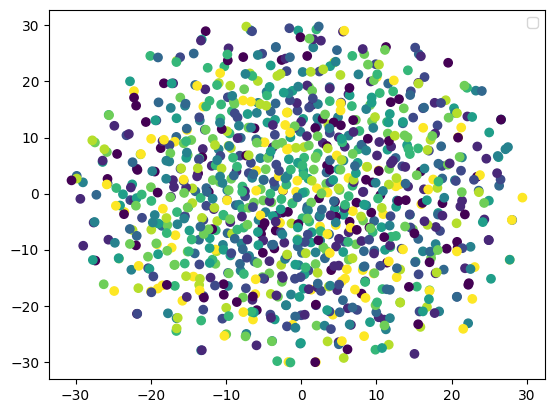

In [43]:
import pandas as pd

data = {
    'component_a': X_tsne[:,0],
    'component_b': X_tsne[:,1],
    'label': y_train[:1000]
}

df = pd.DataFrame(data)

plt.scatter(x=df['component_a'].values, y=df['component_b'].values, c=df['label'])
plt.legend()
plt.show()

In [44]:
inputs = [
    tf.convert_to_tensor(x_train[0]),
    FINAL_ALPHA,
    beta
]

image, z, alpha_hat = model(inputs)

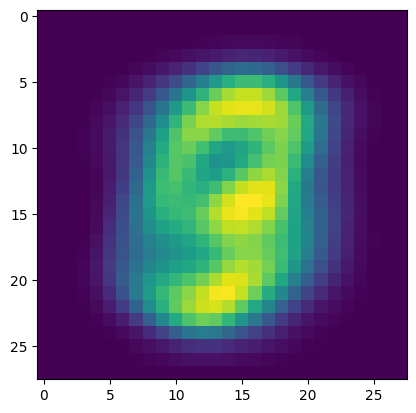

In [45]:
plt.imshow(image[0].numpy())
plt.show()

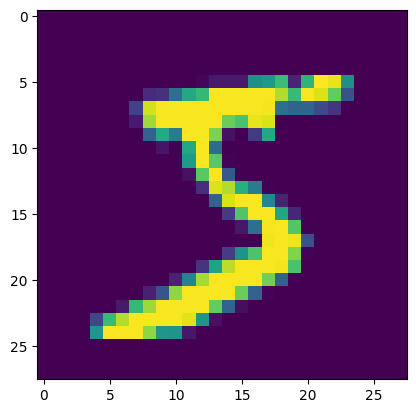

In [46]:
plt.imshow(x_train[0])
plt.show()